# Hopfield recall. Random signal

Generate random signal for the whole time-series. Recall. See if it spikes at a right (corresponding to a memory-graph) moment.

Result: No recall on random signal

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import matplotlib.colors as colors
from scipy import sparse
%matplotlib inline

### Prepare data

In [2]:
PATH_DATA = "/mnt/data/git/WikiBrain/src/main/resources/hopfield/"

In [3]:
shape = (116016, 5279)

In [4]:
content_normal = np.random.normal(0, 1, size=shape)
content_uniform = np.random.uniform(low=-1, high=1, size=shape)
content = np.load(PATH_DATA + "content.npy")

In [7]:
random_content = content_uniform

Match Wiki page ids with row numbers in <code>content</code> matrix to link it with an adjacency matrix

In [8]:
ids = []
for row in content:
    ids.append(int(row[0]))

In [9]:
ids_dict = {}
for i, a in enumerate(ids):
    ids_dict[a] = i

In [10]:
ids_dict_swap = {}
for i, a in enumerate(ids):
    ids_dict_swap[i] = a

Read adjacency matrix and link it to content matrix. In other words, link signal to graph

In [11]:
import csv
with open(PATH_DATA + 'edges_jan_full.csv') as f:
    data=[tuple(line) for line in csv.reader(f)]

In [12]:
row = [ids_dict[int(line[0])] for line in data]
col = [ids_dict[int(line[1])] for line in data]
data = [float(line[2]) if float(line[2]) > 1.0 else 0.0 for line in data]

In [13]:
from scipy.sparse import csr_matrix

In [14]:
W = csr_matrix((data, (row, col)), shape=(len(ids_dict), len(ids_dict)))

In [15]:
W = W + W.transpose()

Binarize signal (1 if active, -1 if inactive). To simplify idea of Hopfield recall process

In [16]:
def binarize(x):
    if x>0.0:
        x = 1.0
    else: x = -1.0
    return x

In [17]:
binarized = np.array([[binarize(x) for x in row] for row in random_content])

Low pass filter to see trends in a signal

In [18]:
def savitzky_golay(y, window_size=747, order=2, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

Data for plotting

In [19]:
months = ['October', 'November', 'December', 'January', 'February', 'March', 'April']
x_month = [i for i in np.arange(8*24, len(content[0]), 30*24)]
x_month[1] = x_month[1] + 24 #October
x_month[2] = x_month[2] + 24 #November
x_month[3] = x_month[3] + 48 #December
x_month[4] = x_month[4] + 72 #January
x_month[5] = x_month[5] + 24 #February
x_month[6] = x_month[6] + 48 #March
x_month[7] = x_month[7] + 48 #April

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 90, 40
rcParams['xtick.labelsize'] = 50
rcParams['ytick.labelsize'] = 50
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

Summary of the original signal (sum activity over pages per hour)

In [21]:
summary = np.array(csr_matrix(binarized+1).sum(axis = 0))[0]

In [22]:
#filter over 169 hours (a week) time window with a polynomial of order 2
#month = 747 hours
filtered = savitzky_golay(summary[1:], window_size=721)

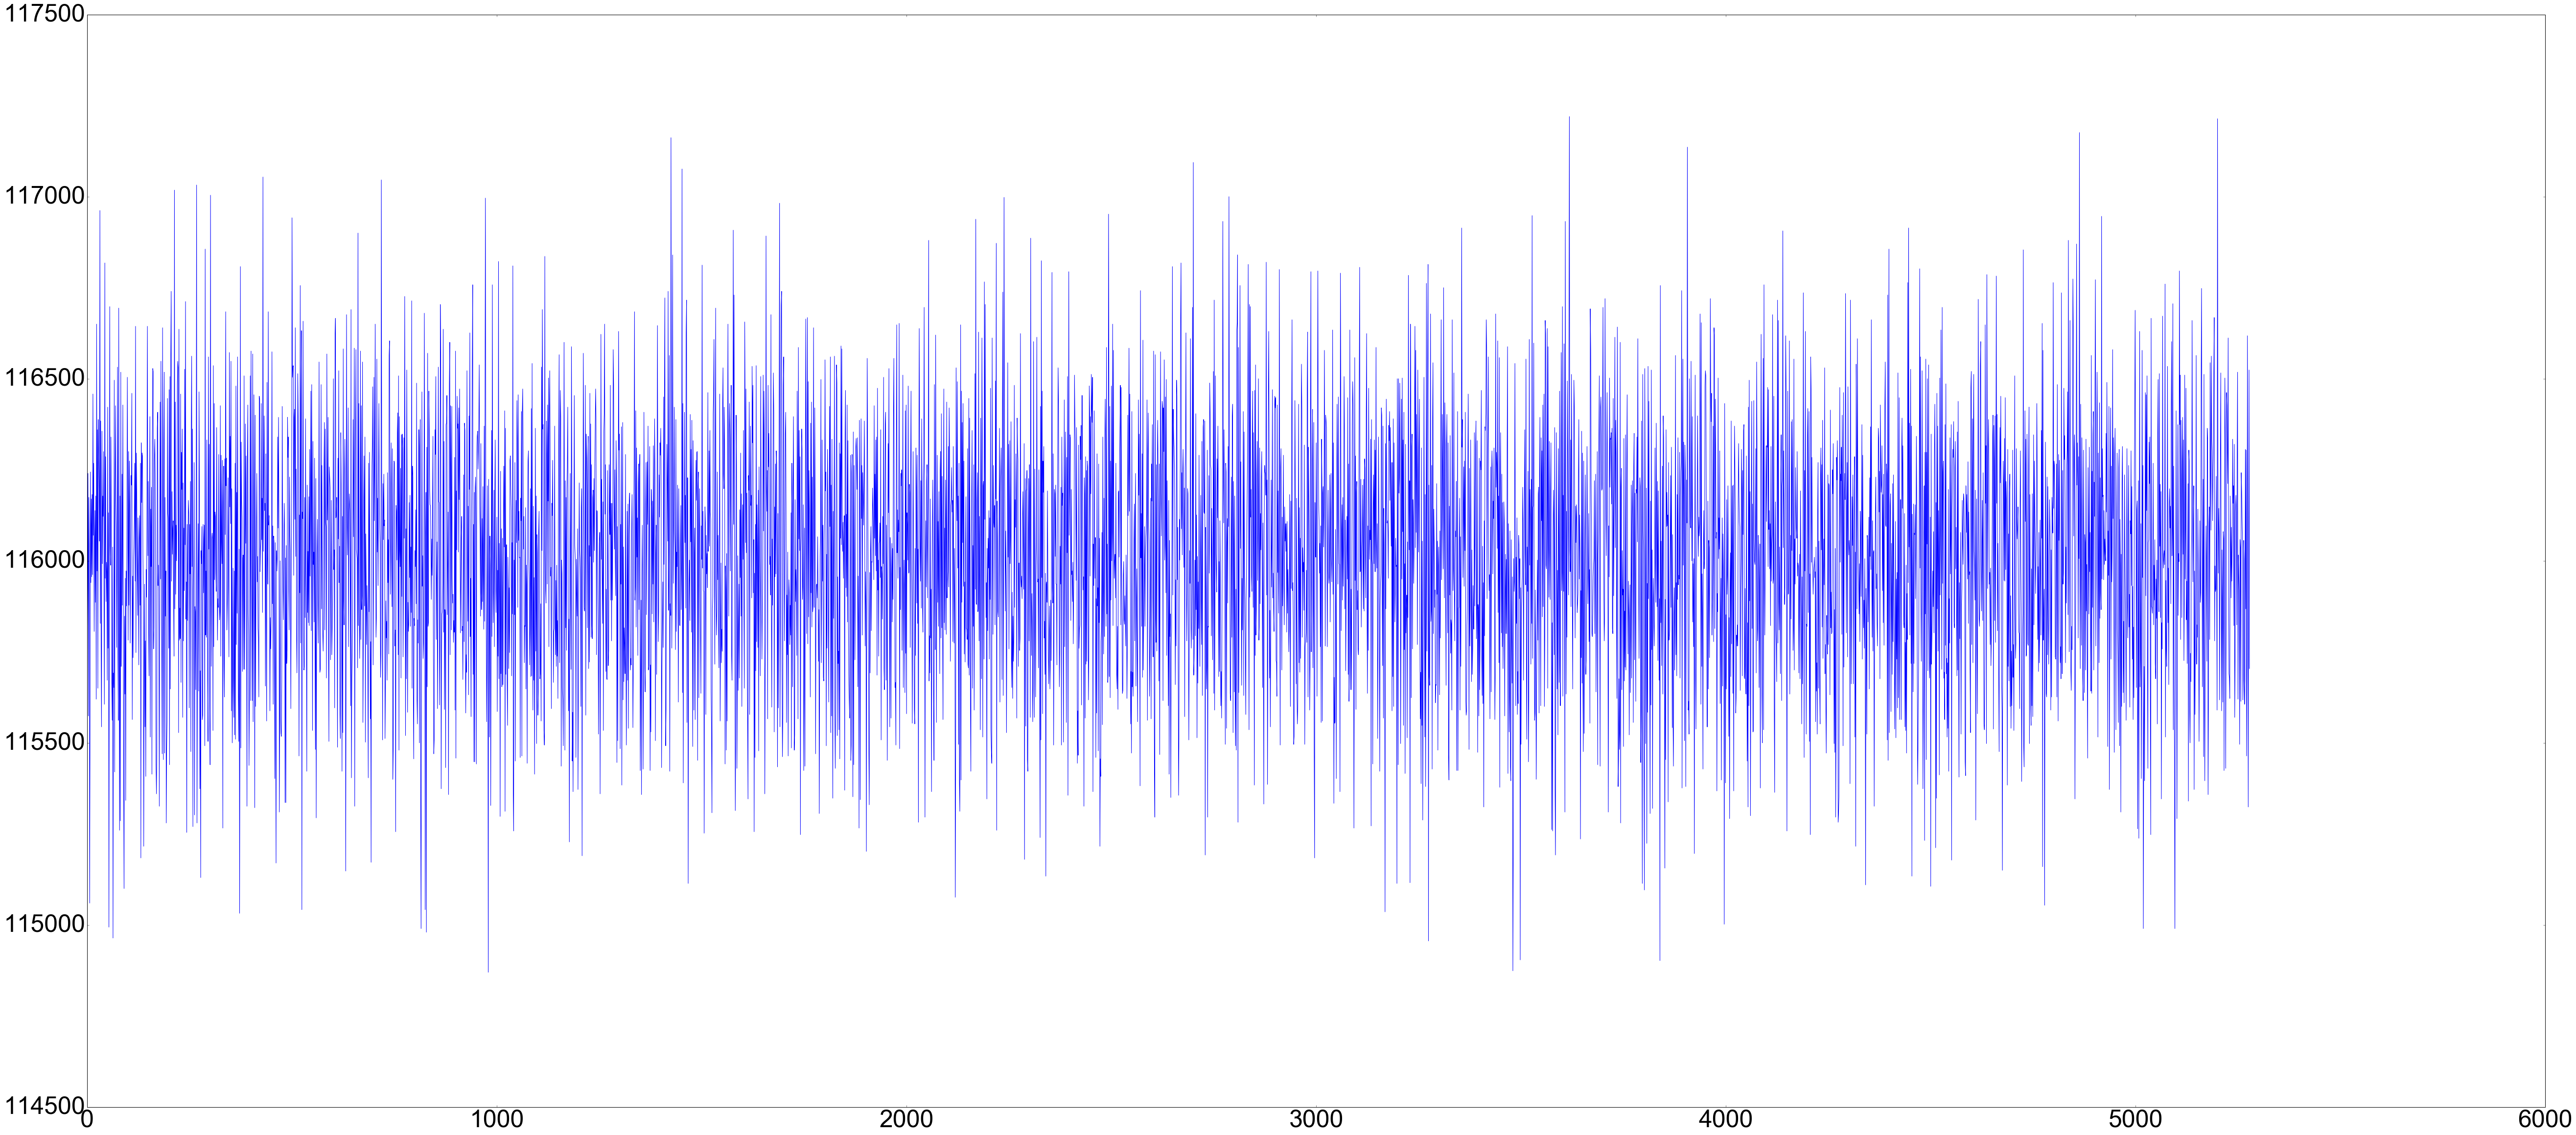

In [23]:
pl.plot(summary)

In [24]:
degraded = csr_matrix(binarized)

### Recall process

In [25]:
r,p = degraded.shape

In [26]:
def recall(W, patterns, steps=5):
    #The tests the network. You give it a pattern and see what it produces
    from numpy import vectorize, dot #vector calculus functions
    sgn = vectorize(lambda x: -1 if x<0 else +1) # convert input pattern into a -1/+1 pattern
    for _ in xrange(steps): #over a number of iterations (defined by 'steps')    
        print "." * (_ + 1)
        patterns = W.dot(patterns) #adjust the neuron activity to reflect the weights
        data = patterns.data
        patterns.data = np.array([-1 if x<0 else +1 for x in data])
    return patterns.todense() #return the final pattern

In [27]:
recalled = recall(W/r, degraded, steps=1)

.


Summary of the signal

In [28]:
summary_recalled = np.array(csr_matrix(recalled+1).sum(axis = 0))[0]

In [29]:
filtered_recalled = savitzky_golay(summary_recalled, window_size=721)

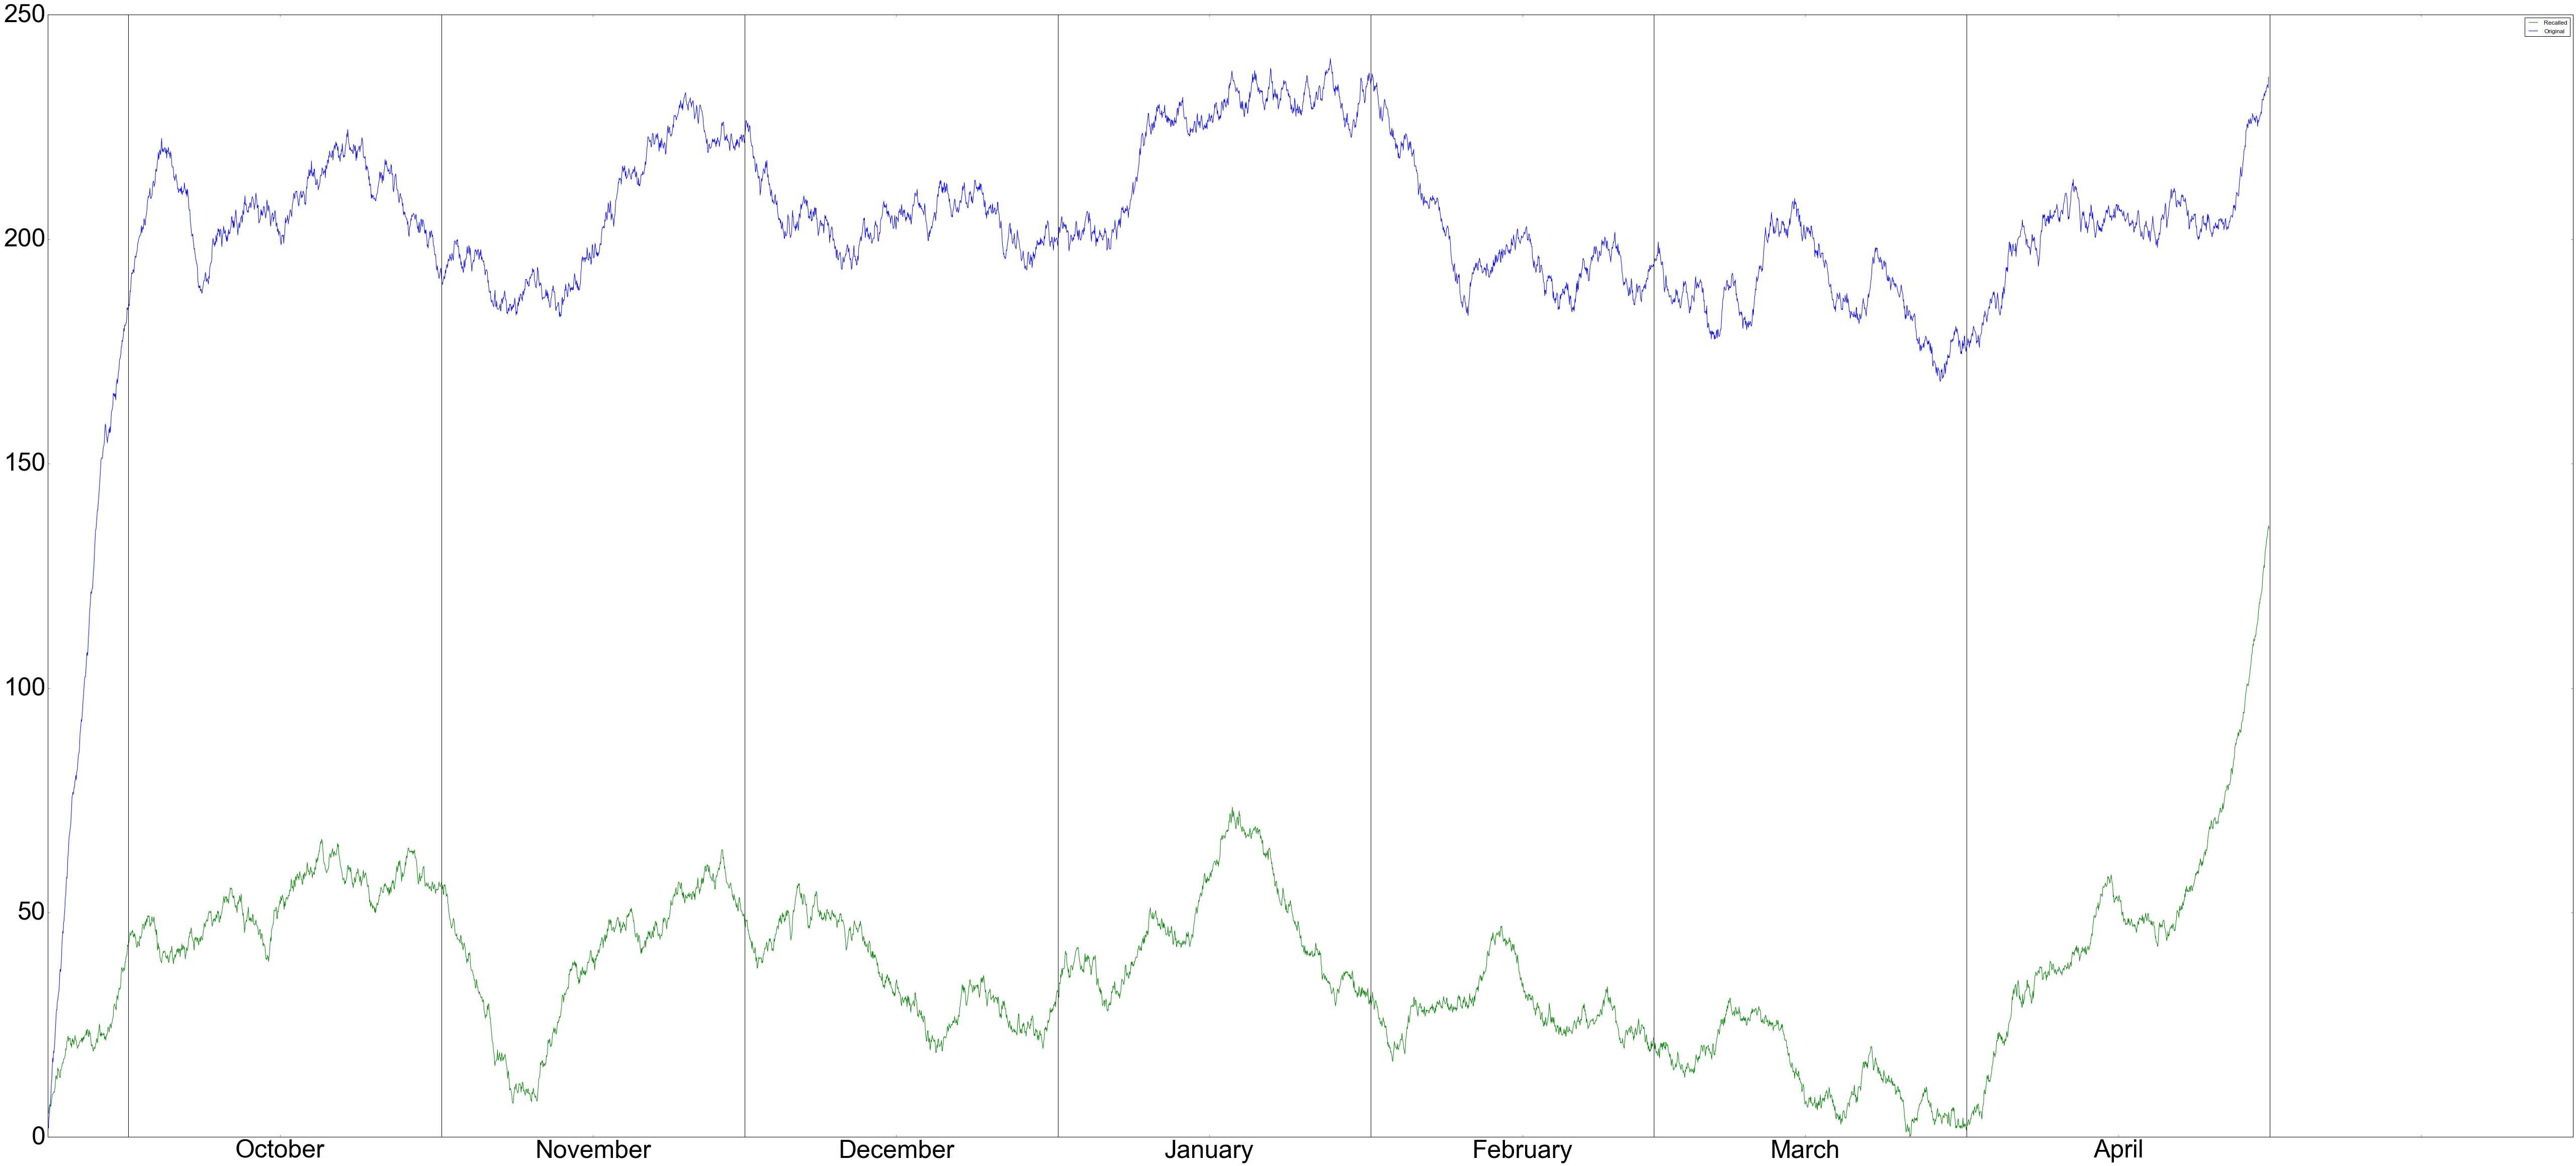

In [30]:
pl.plot(filtered_recalled - min(filtered_recalled), 'g', label="Recalled")
pl.plot(filtered - min(filtered), 'b', label="Original")
pl.legend()
for xc in x_month:
    pl.axvline(x=xc, linewidth=1, color = 'black')
#pl.axvline(x = x_month[3] + 6*24, linewidth=5, color = 'b') #Charlie Hebdo
#pl.axvline(x = x_month[3] + 24*24, linewidth=5, color = 'g') #Miss Universe
#pl.axvline(x = x_month[3] + 9*24, linewidth=5, color = 'm') #Golden Globe
pl.xticks([i + 15*24 for i in x_month], [month for month in months])
pl.show()